In [25]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import defaultdict, deque
import time
import os
import json
from itertools import permutations, islice
import copy

In [2]:
tasks = ['A', 'B', 'C', 'D', 'E']
edges = [('A', 'B'), ('A', 'C'), ('B', 'D'), ('C', 'D'), ('D', 'E')]
delays = {'A': 1, 'B': 1, 'C': 4, 'D': 1, 'E': 3}

In [3]:
class Individual:
    def __init__(self, schedule, edges, delay):
        self.schedule = schedule
        self.fitness = self.calc_fitness(edges, delay)

    #ako ne zadovoljava topsort fitness->inf inace izracunaj max(S)
    def calc_fitness(self, edges, delay):
        if not is_valid_schedule(self.schedule, edges):
            return float('-inf')
        graph, predak = inicialize_graph(edges)
        return -calculate_S(self.schedule, graph, delay, predak)[1]

    def invert(self):
        idx1, idx2 = random.sample(range(len(self.schedule)), 2)
        self.schedule[idx1], self.schedule[idx2] = self.schedule[idx2], self.schedule[idx1]
        return idx1, idx2
            
    def __lt__(self, other):
        return self.fitness < other.fitness

In [4]:
def is_valid_schedule(schedule, edges):
    task_to_index = {task: index for index, task in enumerate(schedule)}
    for u, v in edges:
        if task_to_index[u] > task_to_index[v]:
            return False
    return True

In [5]:
def inicialize_graph(edges):
    graph = defaultdict(list)
    predak = defaultdict(list)

    for u, v in edges:
        graph[u].append(v)
        predak[v].append(u)

    return graph, predak

In [6]:
def calculate_S(permutation, graph, delay, predak):
    S = {t: 0 for t in permutation}
    for node in permutation:
        max_S = S[node]
        for prec in predak[node]:
            max_S = max(S[node], S[prec] + delay[prec] + 1)

        #ako postoji node sa istim S, uvecamo ga za 1
        while max_S in S.values():
            max_S += 1
        S[node] = max_S

    return S, max(S.values())

In [7]:
def create_initial_population(size_of_population, tasks, edges, delays):
    population = [] 
    selected_permutations = list(islice(permutations(tasks), size_of_population))
    random.shuffle(selected_permutations)
    
    for schedule in selected_permutations:
        individual = Individual(list(schedule), edges, delays)
        population.append(individual)
        
    return population

In [8]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen)

In [9]:
def crossover(parent1, parent2):
    idx1, idx2 = sorted(random.sample(range(len(parent1.schedule)), 2))
    child = [None] * len(parent1.schedule)
    child[idx1:idx2+1] = parent1.schedule[idx1:idx2+1]
    
    current_pos = 0
    for task in parent2.schedule:
        if task not in child:
            while child[current_pos] is not None:
                current_pos += 1
            child[current_pos] = task
    return child

In [10]:
def mutate(individual):
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

In [37]:
def simulatedAnnealing(individual, edges, delays, iters=5000, initial_temp=1.0, alpha=0.99):
    best_individual = copy.deepcopy(individual)
    current_temp = initial_temp

    for i in range(1, iters + 1):
        original_schedule = copy.deepcopy(individual.schedule)
        original_fitness = individual.fitness
        
        # Perform a more substantial change (multi-step if necessary)
        idx1, idx2 = individual.invert()
        new_fitness = individual.calc_fitness(edges, delays)
        
        if new_fitness > individual.fitness:
            individual.fitness = new_fitness
        else:
            # Simulated annealing acceptance criteria
            delta_f = new_fitness - individual.fitness
            p = min(1.0, np.exp(delta_f / current_temp))
            q = random.uniform(0, 1)
            if p > q:
                individual.fitness = new_fitness
            else:
                # Revert to original schedule if the change isn't accepted
                individual.schedule = copy.deepcopy(original_schedule)
                individual.fitness = original_fitness
        
        # Update the best individual found
        if individual.fitness > best_individual.fitness:
            best_individual = copy.deepcopy(individual)
        
        # Gradually cool down
        current_temp *= alpha
    
    return best_individual

In [40]:
def genetic_algorithm(population_size, num_generations, 
                      tournament_size, elitism_size, mutation_prob, tasks, edges, delays
                      ):
    population = create_initial_population(population_size, tasks, edges, delays)
    new_population = []
    start_time = time.time()
    
    for i in range(num_generations):
        population = sorted(population, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size):
            parent1 = selection(population, tournament_size)#nz dal se razlikuju
            parent2 = selection(population, tournament_size)

            child_schedule = crossover(parent1, parent2)
            
            if random.random() < mutation_prob:
                mutate(child_schedule)
                
            new_population.append(Individual(child_schedule, edges, delays))

        #poboljsavanje najbolje individue u svakoj generaciji
        #simulatedAnnealing(max(new_population), tasks, edges, delays, iters=10)
        population = new_population.copy()
        
    best_individual = max(population)
    #poboljsavanje najboljeg resenja genetskog algoritma simuliranim kaljenjem
    best_individual = simulatedAnnealing(best_individual, edges, delays)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    print(f'solution: {best_individual.schedule}, cost: {-best_individual.fitness}, time taken: {time_taken}')
    return best_individual.schedule, -best_individual.fitness, time_taken

In [41]:
# Run the genetic algorithm
order, cost, time_taken = genetic_algorithm(
                                            population_size=40, 
                                            num_generations=40, 
                                            tournament_size=9,
                                            elitism_size=7,
                                            mutation_prob=0.5,
                                            tasks=tasks,
                                            edges=edges,
                                            delays=delays
                                            )


solution: ['A', 'C', 'B', 'D', 'E'], cost: 10, time taken: 0.08746623992919922


In [14]:
def draw_graph(tasks, edges, delays, file_name, big_graphs=False, save_path='graphs/'):
    G = nx.DiGraph()
    
    G.add_nodes_from(tasks)
    G.add_edges_from(edges)
    
    # Dynamic figure size based on the number of nodes
    num_nodes = len(tasks)
    if big_graphs:
        plt.figure(figsize=(12 + num_nodes * 0.2, 12 + num_nodes * 0.2))  # Adjust size dynamically
        pos = nx.spring_layout(G, k=0.5, iterations=50)  # Fine-tuned layout for big graphs
    else:
        plt.figure(figsize=(8, 8))  # Default size for small graphs
        pos = nx.spring_layout(G, k=0.8, iterations=50)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1000, font_size=16, font_color='black', arrowstyle='-|>', arrowsize=10)
    
    # Clipping the delays directly below the nodes
    for node, (x, y) in pos.items():
        plt.annotate(f"Delay: {delays[node]}",
                     xy=(x, y), xytext=(0, -20),  # Position text 20 points below the node
                     textcoords='offset points', ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.5), fontsize=10, color='blue')

    file_path = os.path.join(save_path, file_name)
    plt.savefig(file_path)

    plt.show()

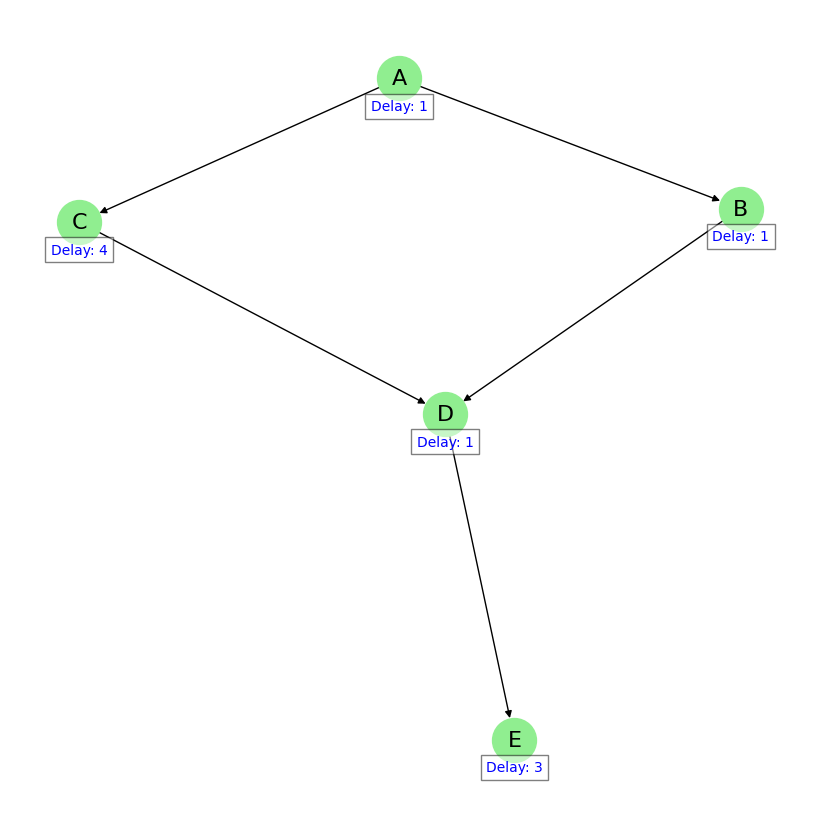

In [16]:
draw_graph(tasks, edges, delays, "inicijalni_primer")

In [17]:
def save_results(file, data):
    with open(file, 'w') as file:
        json.dump(data, file, indent=4)
    print(f"Data saved to {file}")

In [20]:
def test_alg(path_to_test, path_to_results, big_data=False): 
    files = os.listdir(path_to_test)
    data_files = [f for f in files if f.startswith('test_file_') and f.endswith('.json')]
    data_to_write = []

    for file_name in data_files:
        file_path = os.path.join(path_to_test, file_name)
        with open(file_path, 'r') as f:
            loaded_data = json.load(f)
            tasks = loaded_data.get('tasks')
            edges = loaded_data.get('edges')
            delays = loaded_data.get('delays')

            # rough idea of best parameters after performing grid search
            order, cost, time_taken = genetic_algorithm(
                                                        population_size=40, 
                                                        num_generations=40, 
                                                        tournament_size=9,
                                                        elitism_size=7,
                                                        mutation_prob=0.5,
                                                        tasks=tasks,
                                                        edges=edges,
                                                        delays=delays
                                                        )
        
            draw_graph(tasks, edges, delays, file_name[:-5] + "_graph", big_data)
            print("----------------------------------------------")
            data = {
            'test_name' : file_name,
            'order_of_tasks': order,
            'finish_time': cost,
            'time_taken': time_taken
            }
            data_to_write.append(data)
    
    save_results(path_to_results, data_to_write)

### Test on small data

solution: ['B', 'A', 'C', 'E', 'D'], cost: 10, time taken: 0.04913139343261719


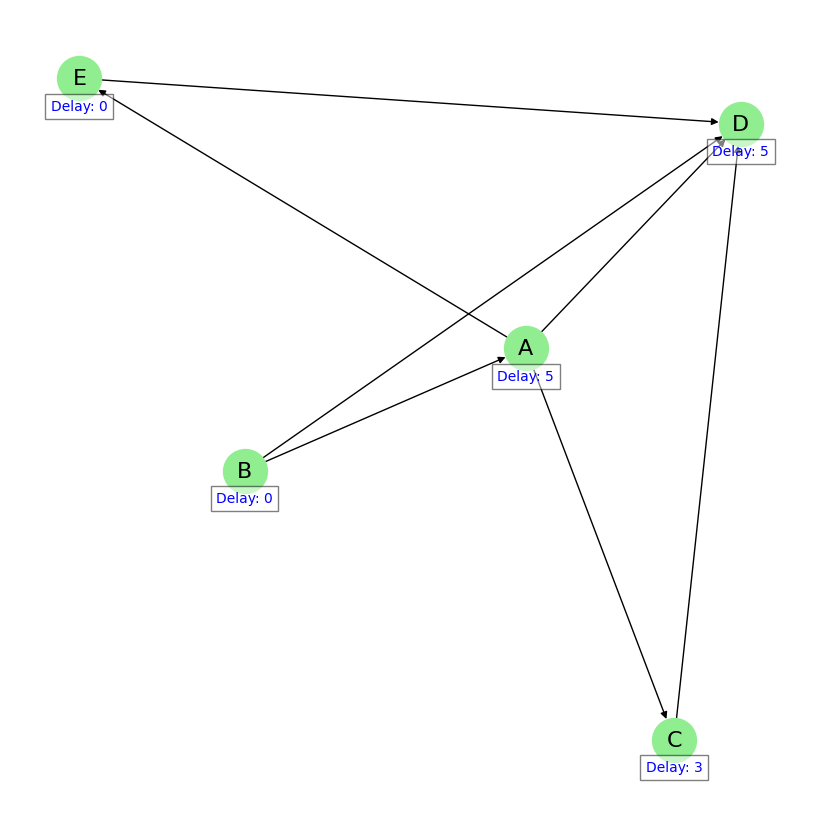

----------------------------------------------
solution: ['D', 'G', 'A', 'B', 'H', 'C', 'E', 'F'], cost: 14, time taken: 0.03925061225891113


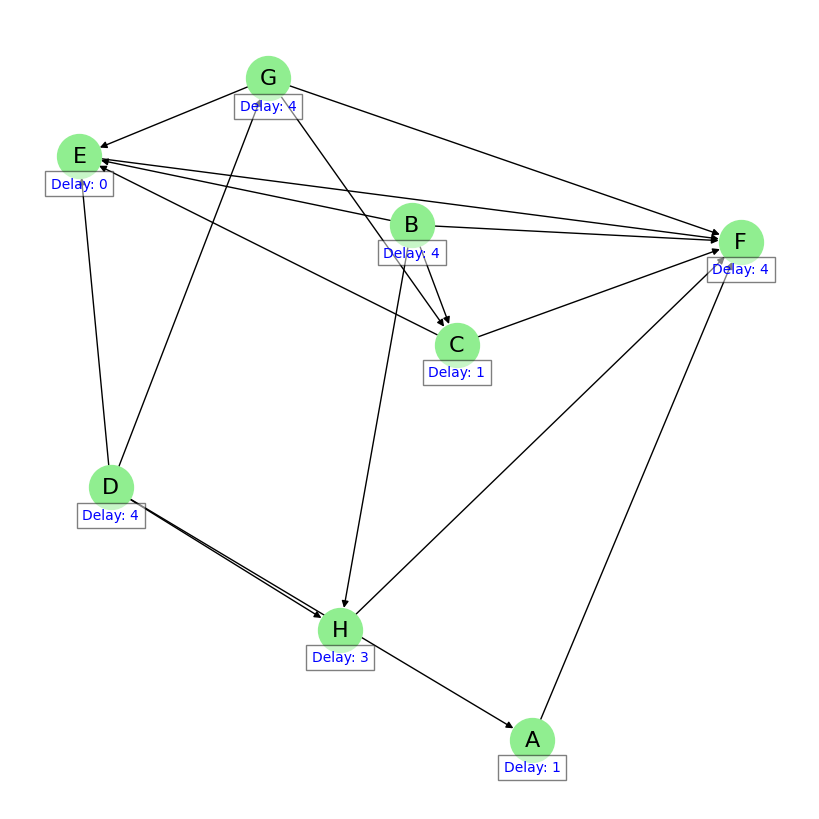

----------------------------------------------
solution: ['B', 'E', 'A', 'D', 'F', 'C', 'G'], cost: 16, time taken: 0.038149356842041016


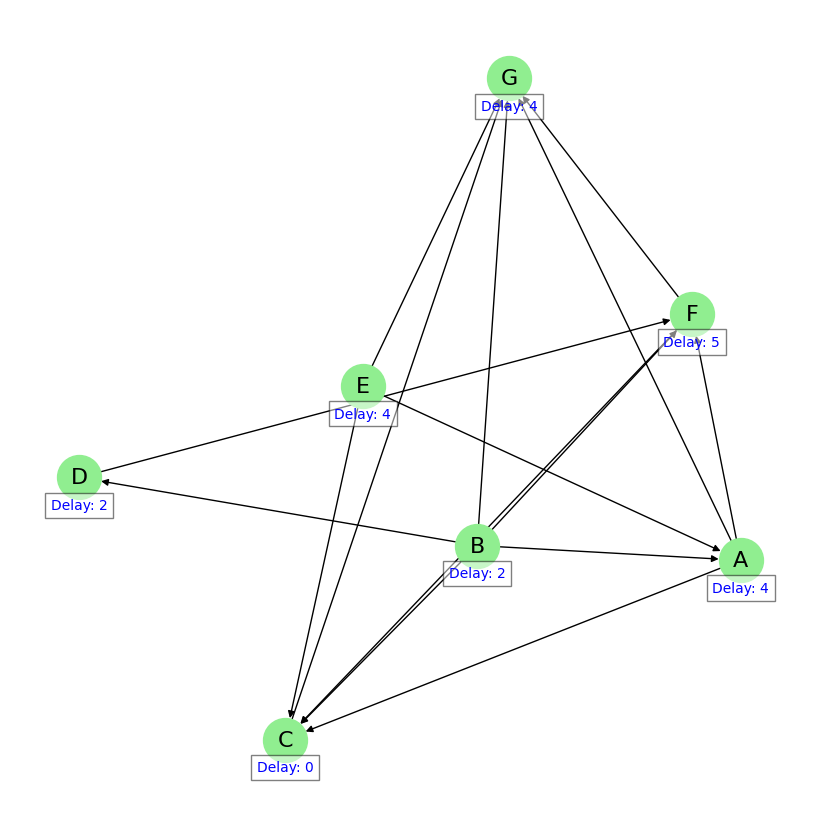

----------------------------------------------
solution: ['B', 'F', 'E', 'A', 'C', 'D'], cost: 13, time taken: 0.036238908767700195


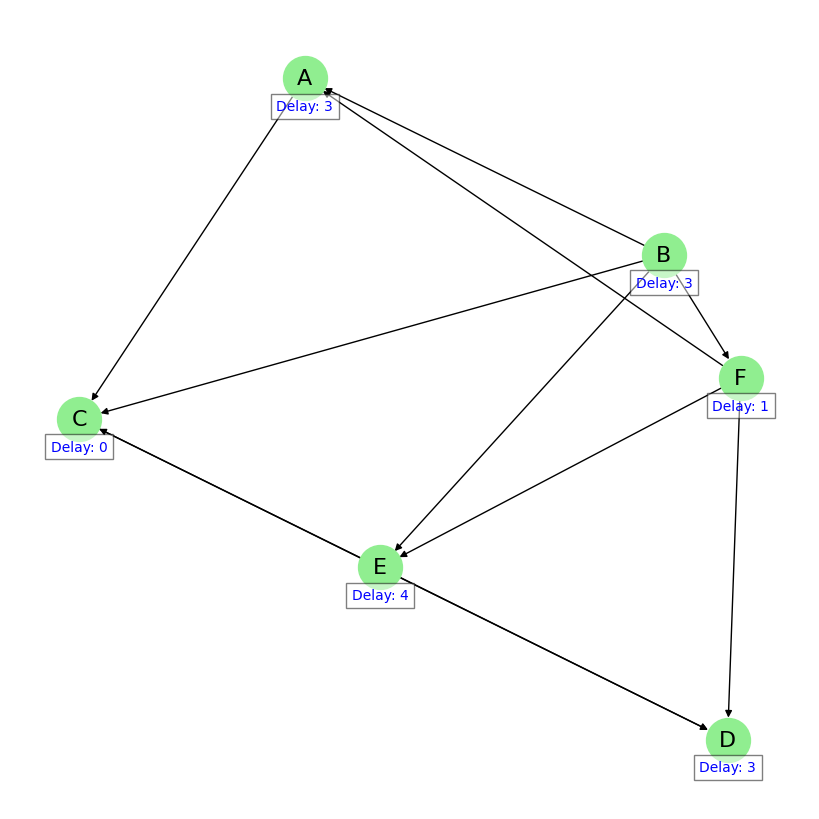

----------------------------------------------
solution: ['C', 'H', 'A', 'E', 'G', 'B', 'D', 'I', 'F'], cost: 11, time taken: 0.06427597999572754


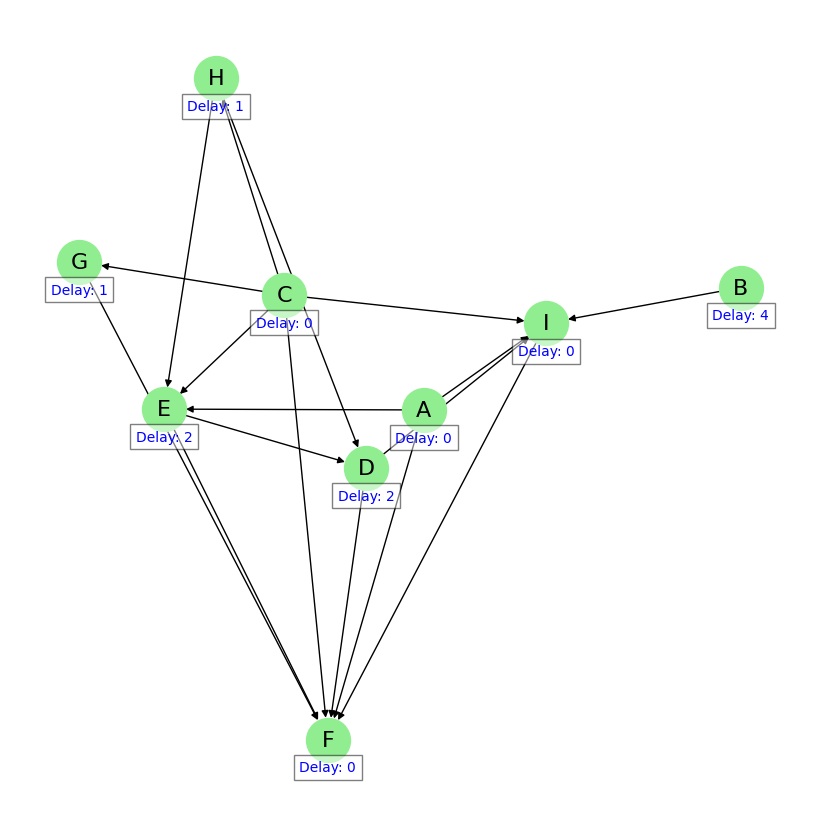

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/small_data/GASA.json' mode='w' encoding='UTF-8'>


In [21]:
test_file = 'test_files/small_data/'
result_file = 'results/small_data/GASA.json'
test_alg(test_file, result_file, False)

### Test on big data

solution: ['J', 'I', 'H', 'Q', 'N', 'K', 'A', 'C', 'U', 'S', 'E', 'P', 'L', 'M', 'D', 'F', 'V', 'R', 'G', 'B', 'O', 'T'], cost: 39, time taken: 0.20120954513549805


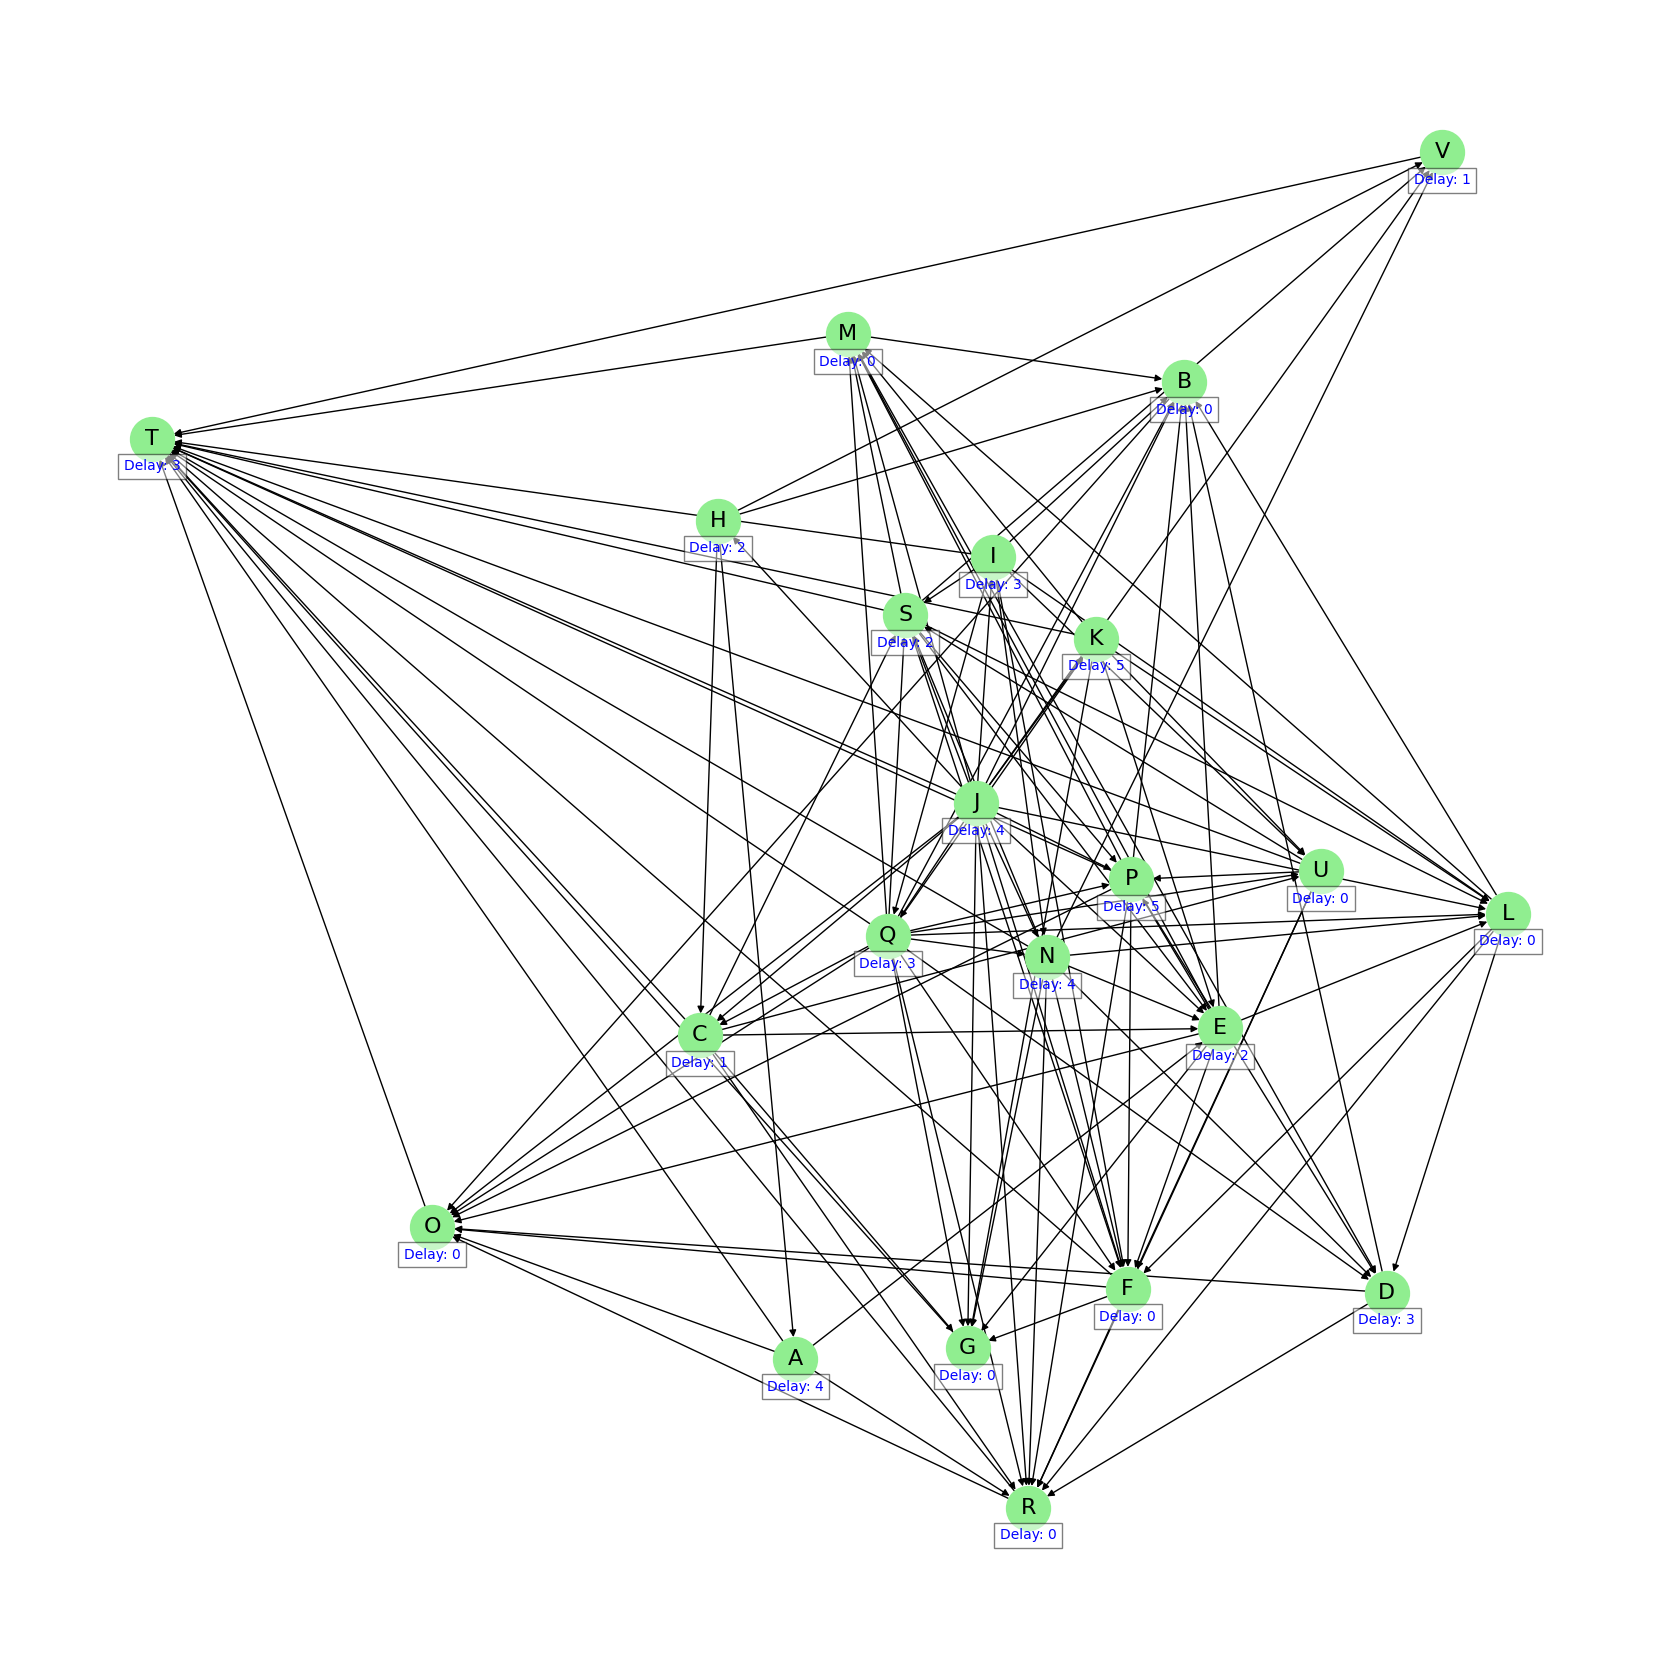

----------------------------------------------
solution: ['H', 'I', 'W', 'F', 'R', 'D', 'Q', 'G', 'U', 'O', 'C', 'P', 'V', 'E', 'X', 'B', 'K', 'T', 'J', 'S', 'M', 'A', 'N', 'L'], cost: 57, time taken: 0.20398211479187012


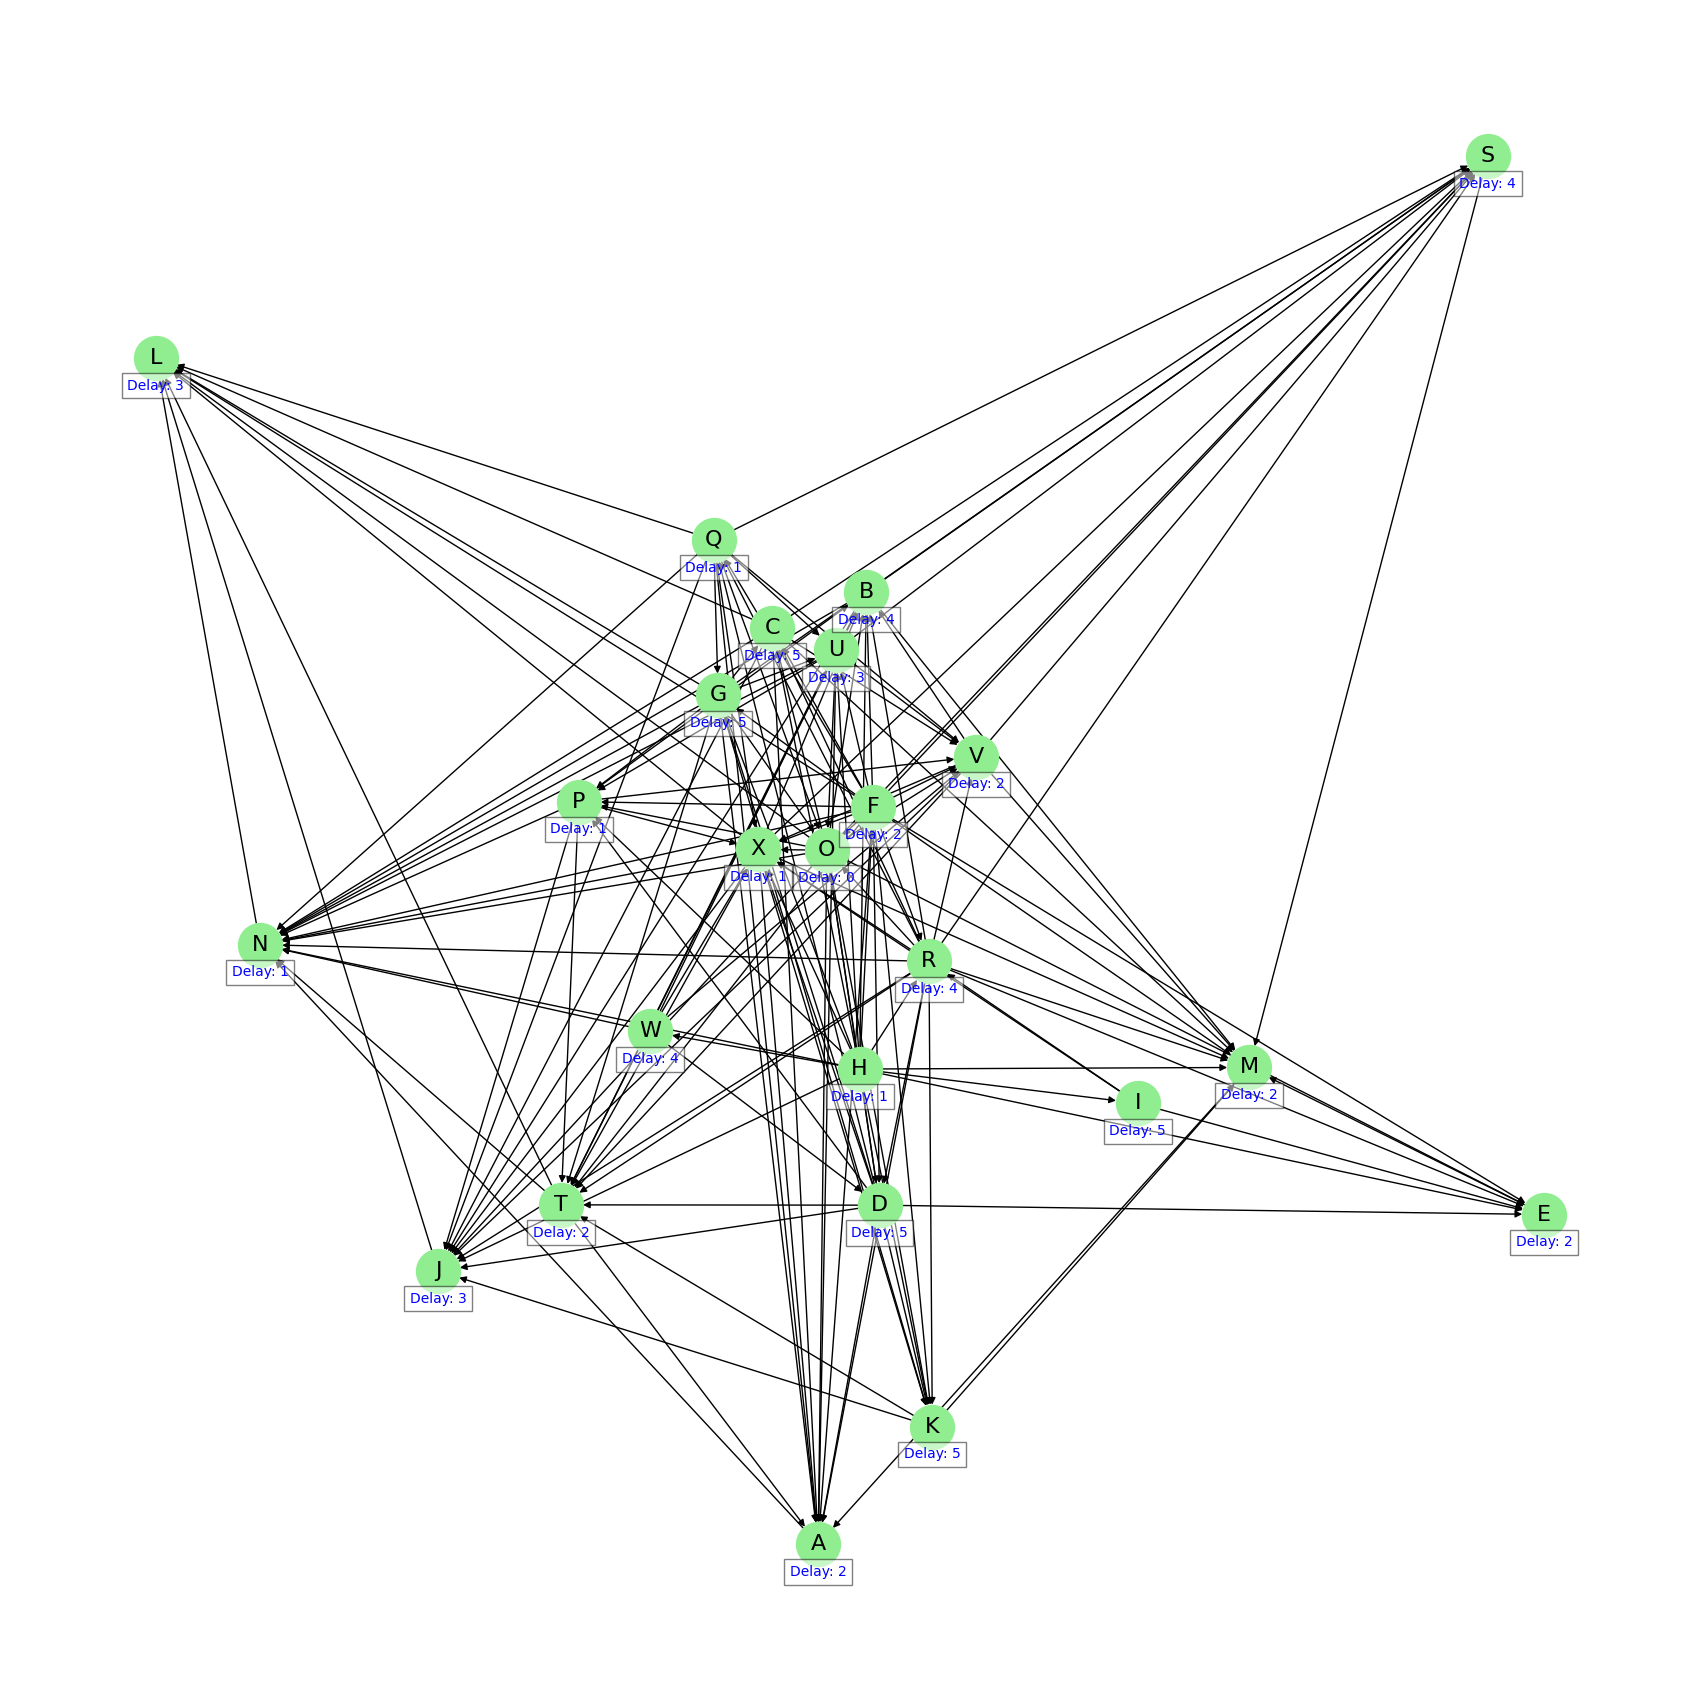

----------------------------------------------
solution: ['E', 'G', 'Q', 'N', 'F', 'M', 'K', 'I', 'O', 'L', 'H', 'S', 'B', 'C', 'D', 'P', 'J', 'R', 'A', 'T'], cost: 49, time taken: 0.17121458053588867


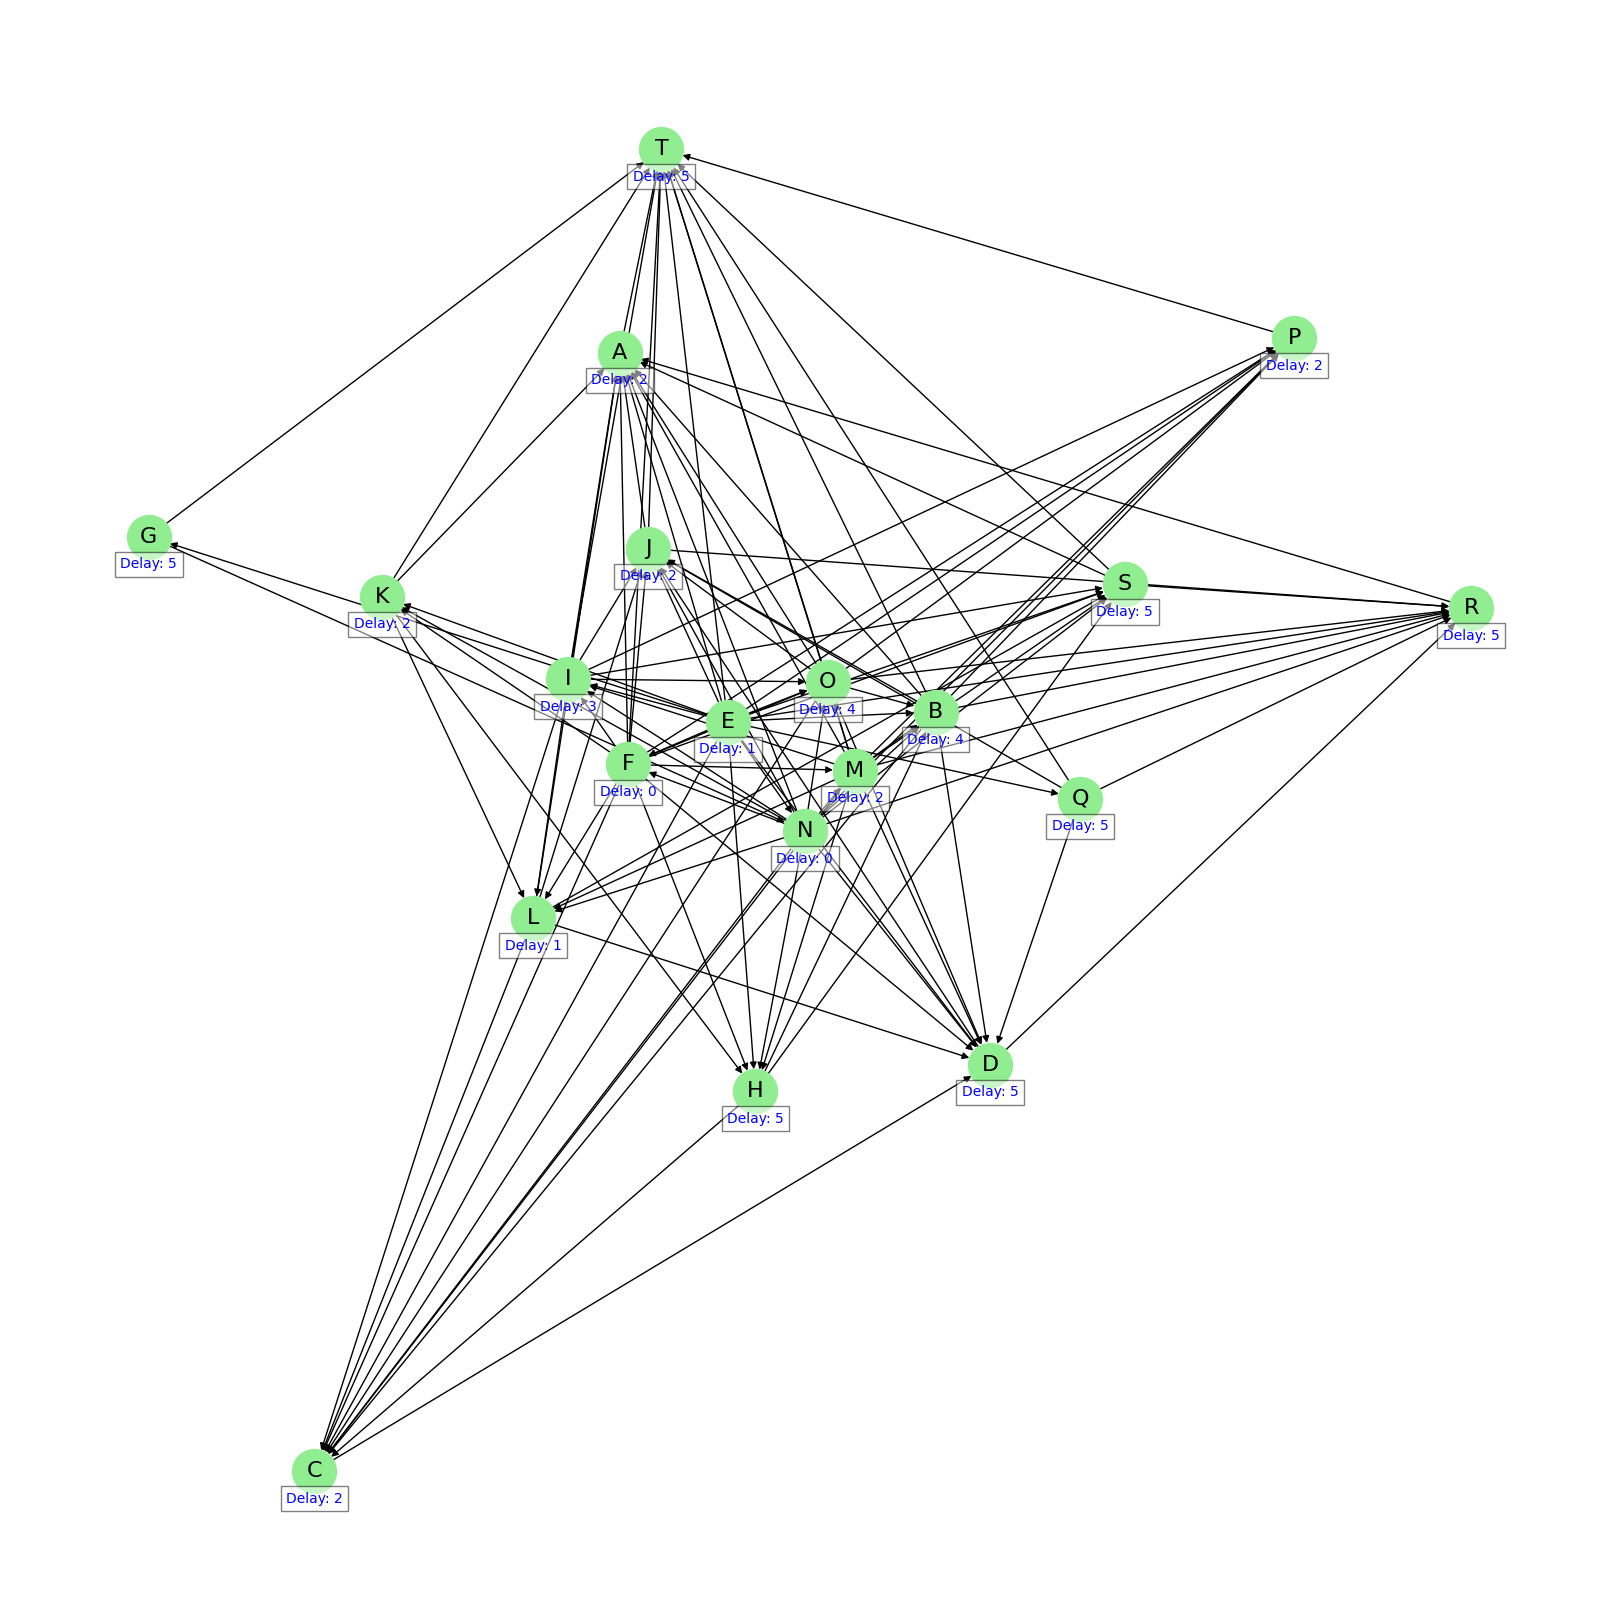

----------------------------------------------
solution: ['B', 'G', 'P', 'K', 'T', 'Q', 'M', 'I', 'A', 'H', 'C', 'S', 'J', 'R', 'D', 'O', 'F', 'N', 'U', 'L', 'E'], cost: 41, time taken: 0.17939472198486328


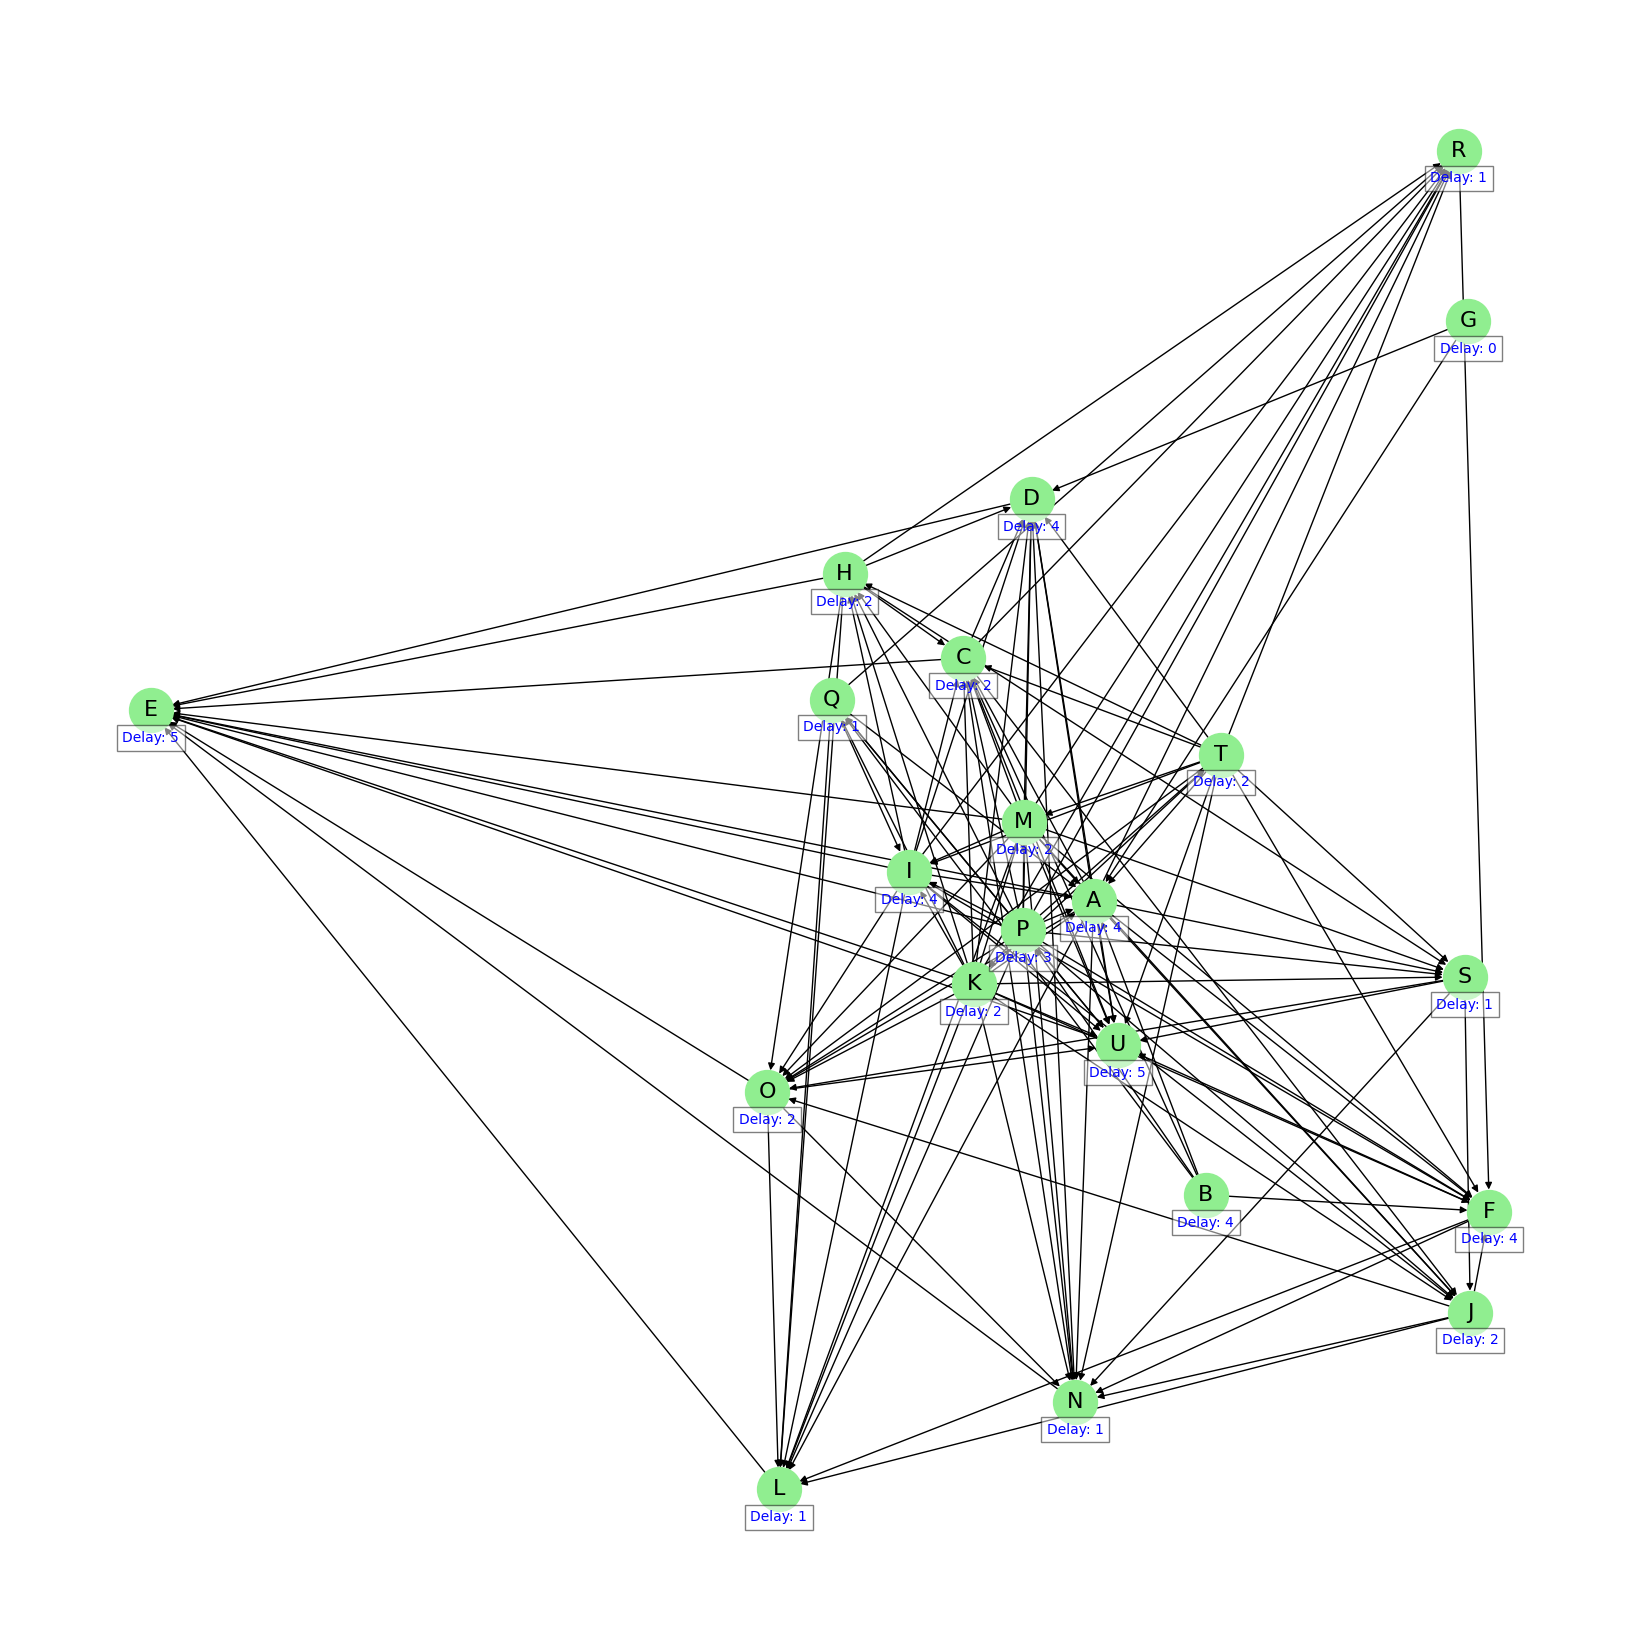

----------------------------------------------
solution: ['N', 'J', 'S', 'K', 'C', 'W', 'H', 'B', 'A', 'G', 'L', 'D', 'Q', 'V', 'P', 'I', 'O', 'E', 'U', 'T', 'M', 'F', 'R'], cost: 44, time taken: 0.19262385368347168


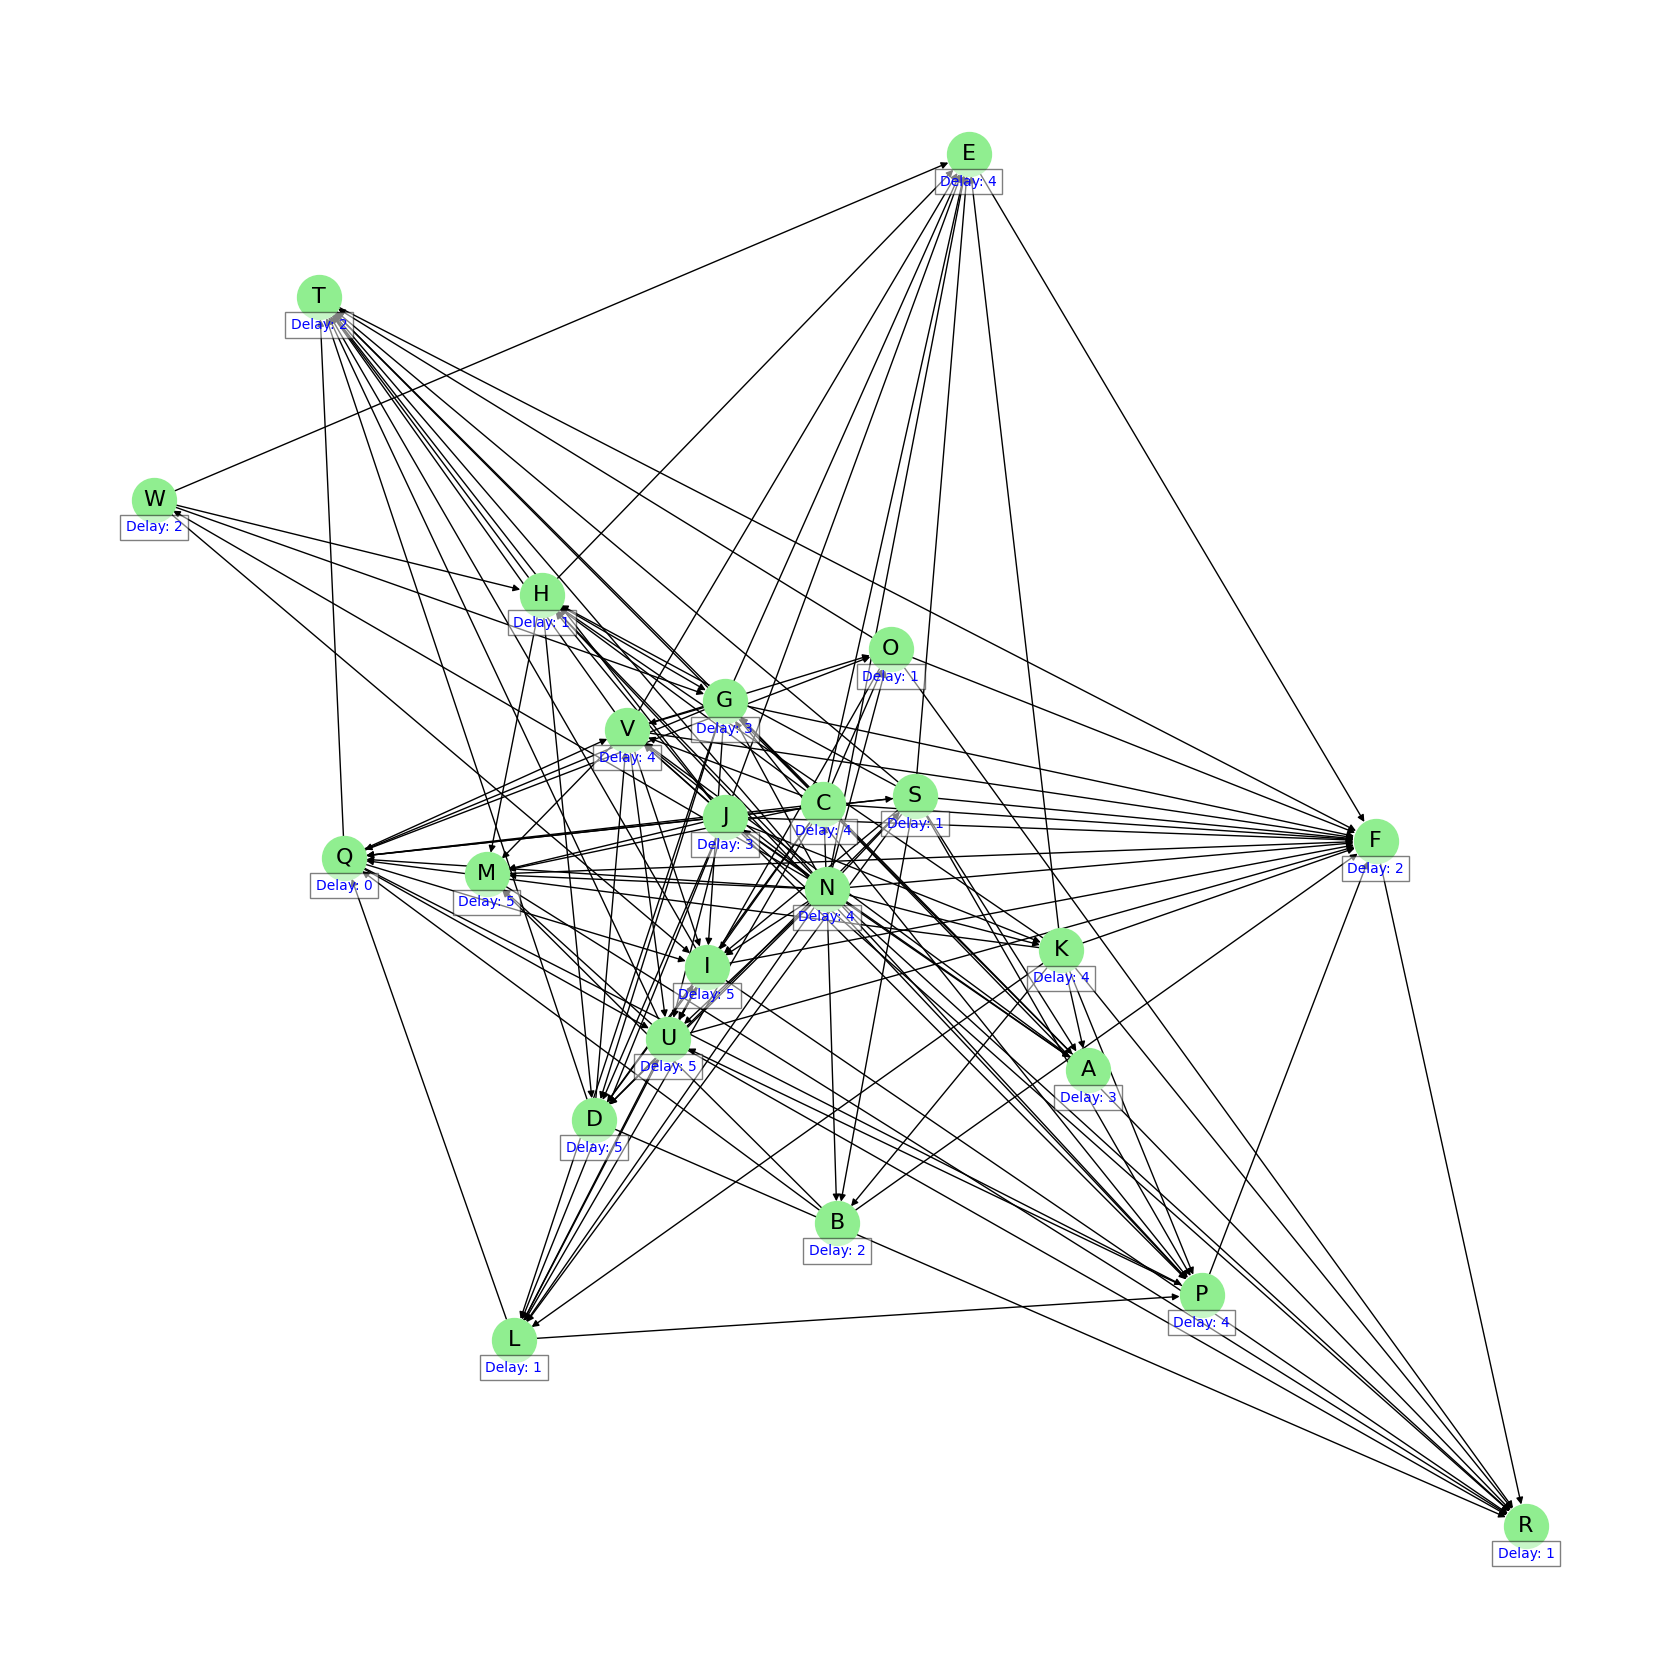

----------------------------------------------
Data saved to <_io.TextIOWrapper name='results/big_data/GASA.json' mode='w' encoding='UTF-8'>


In [42]:
test_file = 'test_files/big_data/'
result_file = 'results/big_data/GASA.json'
test_alg(test_file, result_file, True)